In [1]:
# Importo librerias necesarias
import warnings
warnings.filterwarnings("ignore")
import numpy as np # librería para poder usar arreglos
import pandas as pd # librería para poder usad DataFrames (tablas)
import plotly.express as px
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot
import sklearn # librería para poder usar modelos de machine learning
import os
import urllib.request
import json

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


In [3]:
def get_data():
    """
    Funcion para obtener los datos del archivo covid.csv
    """

    dataSet = pd.read_csv("covid.csv", header=0)
    dataSet.set_index('date', inplace=True)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def infoData(dataSet):
    """
    Funcion para obtener datos generales
    """

    print(dataSet.head(10))
    print("")
    print(dataSet.info())
    print("")
    print(dataSet.isnull().sum())
    print("")

In [4]:
data = get_data()
infoData(data)


            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26               0                0                    0         0   
2020-02-27               0                0                    0         0   
2020-02-28               0                0                    0         0   
2020-02-29               0                0                    0         0   
2020-03-01               0                0                    0         0   
2020-03-02               0                0                    0         0   
2020-03-03               0                0                    0         0   
2020-03-04               0                0                    0         0   
2020-03-05               0                0                    0         0   
2020-03-06               0                0                    0         0   

            CHIAPAS  CHIHUAHUA  DISTRITO FEDERAL  COAHUILA  COL

In [5]:
def map(dataSet):
    """
    Funcion para visualizar la evolución de casos de Covid-19 en los estados de México usando un mapa de calor interactivo con plotly.
    """

    # Asegurarse de que el índice es de tipo fecha y resetearlo para tenerlo como columna
    df = dataSet.copy()
    df = df.reset_index()
    df.rename(columns={'date': 'Fecha'}, inplace=True)

    # Lista de estados (todas las columnas excepto 'Fecha' y 'Nacional')
    estados = [col for col in df.columns if col not in ['Fecha', 'Nacional']]

    # Convertir el dataframe a formato largo para plotly
    df_long = df.melt(id_vars=['Fecha'], value_vars=estados, var_name='Estado', value_name='Casos')

    # Cargar geojson de México (estados)
    # Puedes descargar un geojson de los estados de México, por ejemplo desde: https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json
    # Aquí se asume que el archivo se llama 'mexico_estados.geojson' y está en el mismo directorio
    with open('mexico_estados.geojson', 'r', encoding='utf-8') as f:
        mexico_geojson = json.load(f)

    # Crear el mapa animado
    fig = px.choropleth(
        df_long,
        geojson=mexico_geojson,
        locations='Estado',
        color='Casos',
        animation_frame='Fecha',
        featureidkey='properties.NOM_ENT',  # Depende del geojson, puede ser 'properties.NOM_ENT' o 'properties.name'
        color_continuous_scale='Reds',
        scope='world',
        labels={'Casos': 'Casos normalizados'},
        title='Evolución de casos de Covid-19 por estado en México'
    )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

In [6]:
%pip show nbformat

Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior writte

In [ ]:
#Running `%pip install nbformat` in a Jupyter notebook should install the `nbformat` package. However, if you still see the error `ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed`, possible reasons include:

#1. **Kernel Restart Needed:** After installing a new package, you often need to restart the Jupyter kernel for the changes to take effect.
#2. **Multiple Python Environments:** The notebook kernel might be using a different Python environment than the one where `nbformat` was installed.
#3. **Installation Failed:** The installation may have failed silently or with a warning.

#**How to fix:**
#- Run `%pip show nbformat` in a cell to check if it is installed and its version.
#- If not installed, run `%pip install nbformat --upgrade` and then restart the kernel.
#- Make sure your notebook is running in the same environment where you installed `nbformat`.

#If the problem persists, check your Jupyter server logs for more details.
map(data)

In [ ]:
def preprocess_data(dataSet):
    """
    Funcion para el preprocesamiento de datos
    """

    local_dataSet = dataSet.dropna()
    columns_list = dataSet.columns.tolist()
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(local_dataSet)
    new_dataSet = min_max_scaler.transform(local_dataSet)

    new_dataSet = pd.DataFrame(np.round(new_dataSet,4), columns=columns_list)
    new_dataSet.index = local_dataSet.index

    return new_dataSet

In [ ]:
preprocessData = preprocess_data(data)

plt.figure(figsize=(10, 8))
plt.plot(preprocessData['Nacional'])
plt.title('Datos nacional', fontweight='bold')
plt.show()

In [8]:
def pca_Transformation(dataSet):
    features = dataSet
    features = features.drop(['Nacional'], axis=1)

    # principal components analysis
    pca = sk.PCA(n_components=3)
    principalComponents = pca.fit_transform(features)
    principalComp = pd.DataFrame(data = principalComponents,
                                 columns = ['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3'])
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp['Nacional'] = dataSet['Nacional']
    cols = principalComp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    principalComp = principalComp[cols]

    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    varRatio = (pca.explained_variance_ratio_)*100
    data = {'P. Comp. 1':varRatio[0],'P. Comp. 2':varRatio[1],'P. Comp. 3':varRatio[2]}
    dfVar = pd.DataFrame(data, index=['Exp Var Ratio %'])
    print(dfVar)
    print("\n")

    return principalComp

In [9]:
pcaData = pca_Transformation(preprocessData)
pcaData.head(1215)

                 PCA ANALYSIS
----------------------------------------------------------
            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2023-06-20    0.0055   -0.385418   -0.023980   -0.031617
2023-06-21    0.0050   -0.389817   -0.025970   -0.026036
2023-06-22    0.0048   -0.394643   -0.029628   -0.022447
2023-06-23    0.0026   -0.401546   -0.021571   -0.028535
2023-06-24    0.0002   -0.419864   -0.024882   -0.014331

[1215 rows x 4 columns]


                 P. Comp. 1  P. Comp. 2  P. Comp. 3
Exp Var Ratio %   81.101835    5.824434    3.614026




,Nacional,P. Comp. 1,P. Comp. 2,P. Comp. 3
date,,,,
2020-02-26,0.0000,-0.420984,-0.025472,-0.013954
2020-02-27,0.0000,-0.420786,-0.025421,-0.013903
2020-02-28,0.0000,-0.420896,-0.025544,-0.013894
2020-02-29,0.0000,-0.420792,-0.025320,-0.014072
2020-03-01,0.0000,-0.420784,-0.025356,-0.013891
...,...,...,...,...
2023-06-20,0.0055,-0.385418,-0.023980,-0.031617
2023-06-21,0.0050,-0.389817,-0.025970,-0.026036
2023-06-22,0.0048,-0.394643,-0.029628,-0.022447


In [10]:
train_data, test_data = train_test_split(pcaData, test_size=0.25, shuffle=False)
print(train_data.head(1215))
print("")
print(len(train_data))
print("")
print(test_data.head(1215))
print("")
print(len(test_data))

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2022-08-20    0.0210   -0.287385    0.002451    0.002460
2022-08-21    0.0187   -0.293690    0.000125    0.009103
2022-08-22    0.0691   -0.015549    0.005202    0.060701
2022-08-23    0.0507   -0.102404    0.010890    0.055541
2022-08-24    0.0462   -0.132828    0.019228    0.046232

[911 rows x 4 columns]

911

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2022-08-25    0.0404   -0.171591    0.015264    0.020806
2022-08-26    0.0362   -0.204175    0.005791    0.015538
2

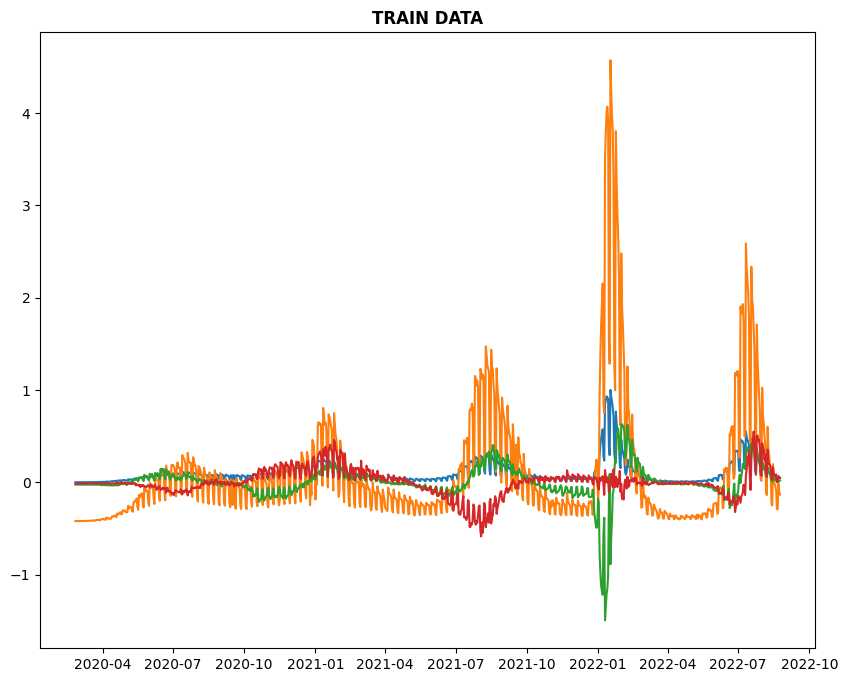

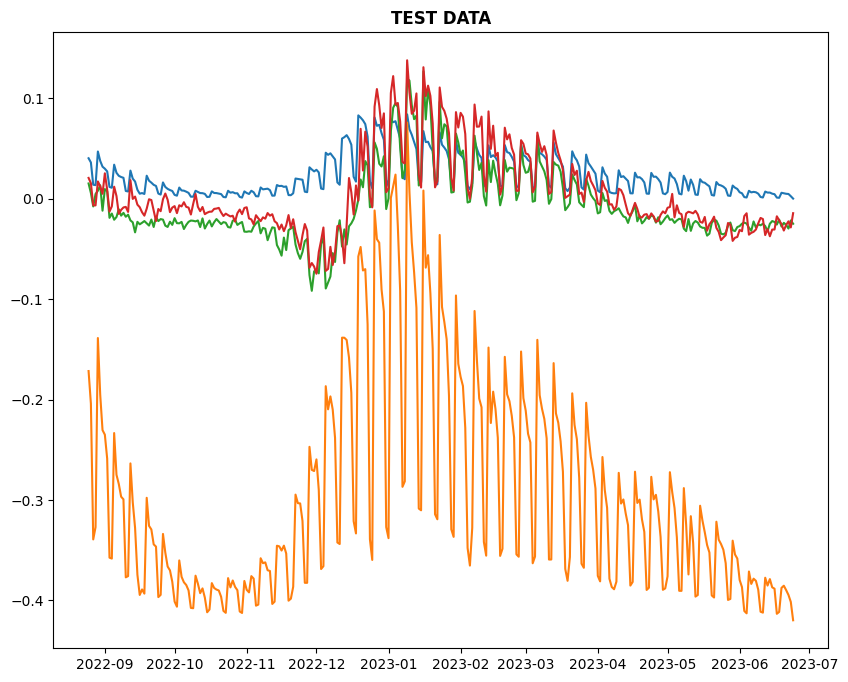

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(train_data)
plt.title('TRAIN DATA', fontweight='bold')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(test_data)
plt.title('TEST DATA', fontweight='bold')
plt.show()

Modelado del PCA

In [12]:
# Decision Tree Regressor
dt_regr = DecisionTreeRegressor()
param_search_dt_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}
# Puedo probar con'min_samples_split': [2, 5, 10],
# Puedo probar con'min_samples_leaf': [1, 2, 4]

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['Nacional']]
y = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]

grid_search_dt = GridSearchCV(estimator=dt_regr, param_grid=param_search_dt_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_dt.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_dt = grid_search_dt.best_params_

print("==========================================================")
print("Best parameters for Decision Tree Regressor:")
print(best_params_dt)
print("----------------------------------------------------------")


Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best parameters for Decision Tree Regressor:
{'criterion': 'squared_error', 'max_depth': 3}
----------------------------------------------------------


In [13]:
# === Definición de variables (X e Y) ===
X_train = train_data.iloc[:, [-1]]  # Nacional
Y_train = train_data.iloc[:, 0:3]  # P. Comp. 1, 2, 3

X_test = test_data.iloc[:, [-1]]
Y_test = test_data.iloc[:, 0:3]

In [14]:
# === MultiOutputRegressor para predecir los 3 componentes principales ===
multi_dt = MultiOutputRegressor(grid_search_dt.best_estimator_)
multi_dt.fit(X_train, Y_train)

# === Predicciones ===
train_pred = multi_dt.predict(X_train)
test_pred = multi_dt.predict(X_test)

# === Convertir a DataFrames para análisis ===
pred_train_df = pd.DataFrame(train_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_train.index)
pred_test_df = pd.DataFrame(test_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_test.index)

Y_train.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
Y_test.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_train_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_test_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]

# === Utilizando el mismo proceso de evaluación como en la primer tarea, el cambio ahora es que se usa para los 3 componentes del análisis PCA ===
def evaluacion_metricas(true_df, pred_df):
    metrics = {}
    for col in true_df.columns:
        n = len(true_df[col])
        k = 1  # number of predictors (for each PCA component, only one output, but you may adjust if needed)
        mse = mean_squared_error(true_df[col], pred_df[col])
        mae = mean_absolute_error(true_df[col], pred_df[col])
        mape = mean_absolute_percentage_error(true_df[col], pred_df[col])
        r2 = r2_score(true_df[col], pred_df[col])
        rmse = mse ** 0.5

        # AIC and BIC for regression (assuming Gaussian errors)
        # log-likelihood for Gaussian: -n/2 * log(2*pi*sigma^2) - (1/(2*sigma^2)) * sum((y-yhat)^2)
        # For AIC/BIC, sigma^2 is estimated as mse
        if mse > 0:
            log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
            aic = 2 * k - 2 * log_likelihood
            bic = np.log(n) * k - 2 * log_likelihood
        else:
            aic = np.nan
            bic = np.nan

        # Amemiya's Prediction Criterion (APC)
        # APC = (1 + (k/n)) * mse
        apc = (1 + (k / n)) * mse

        metrics[col] = {
            "MSE": mse,
            "MAE": mae,
            "MAPE": mape,
            "R2": r2,
            "RMSE": rmse,
            "AIC": aic,
            "APC": apc,
            "BIC": bic
        }
    return pd.DataFrame(metrics).T

train_metrics = evaluacion_metricas(Y_train, pred_train_df)
test_metrics = evaluacion_metricas(Y_test, pred_test_df)

print("\n Métricas por componente - Train:")
print(train_metrics)
print("\n Métricas por componente - Test:")
print(test_metrics)


 Métricas por componente - Train:
                 MSE       MAE          MAPE        R2      RMSE          AIC  \
P. Comp. 1  0.013354  0.059005  1.496964e+12  0.181686  0.115557 -1344.548147   
P. Comp. 2  0.360649  0.319649  2.446717e+00  0.198981  0.600541  1658.223094   
P. Comp. 3  0.030319  0.092962  2.003629e+00  0.132981  0.174125  -597.518241   

                 APC          BIC  
P. Comp. 1  0.013368 -1339.733604  
P. Comp. 2  0.361045  1663.037637  
P. Comp. 3  0.030353  -592.703698  

 Métricas por componente - Test:
                 MSE       MAE      MAPE        R2      RMSE         AIC  \
P. Comp. 1  0.002427  0.046967  7.116137 -4.784790  0.049269 -965.642393   
P. Comp. 2  0.075876  0.265464  2.093481 -5.581120  0.275456   80.802739   
P. Comp. 3  0.004581  0.049675  2.209206 -2.485007  0.067684 -772.571733   

                 APC         BIC  
P. Comp. 1  0.002435 -961.925365  
P. Comp. 2  0.076125   84.519767  
P. Comp. 3  0.004596 -768.854705  


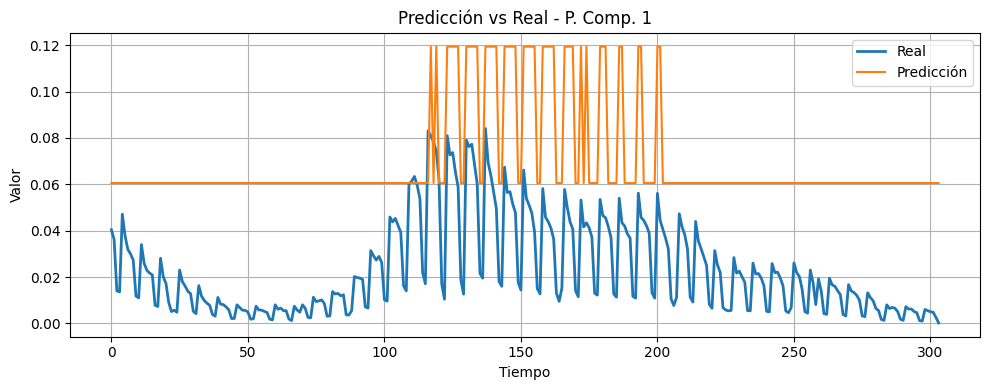

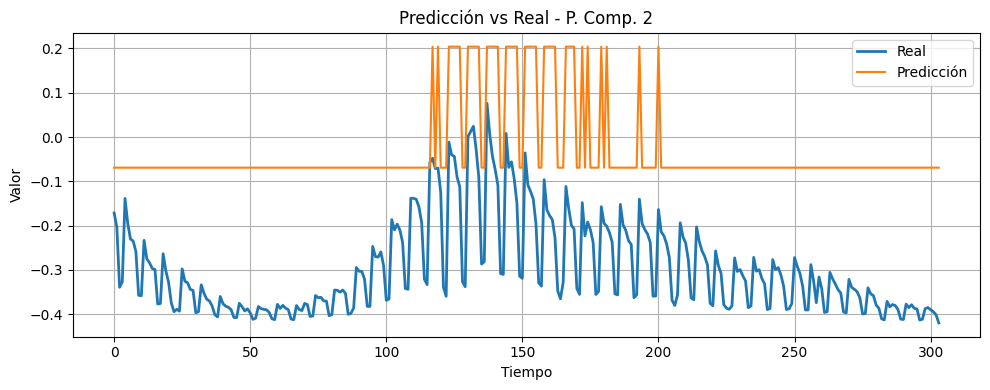

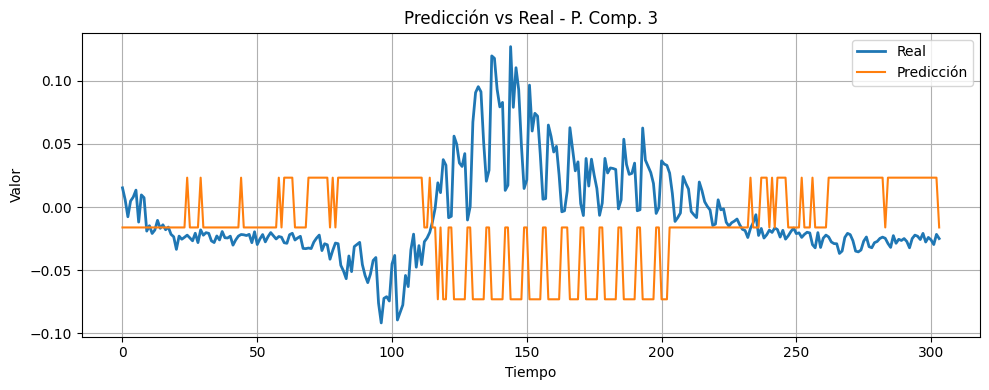

In [15]:
# == Gráfica de cada componente en test ==
for col in Y_test.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[col].values, label="Real", linewidth=2)
    plt.plot(pred_test_df[col].values, label="Predicción", linestyle="-")
    plt.title(f"Predicción vs Real - {col}")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
# Random forest
rf_regr = RandomForestRegressor()
param_search_rf_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'n_estimators': [10, 50, 100, 200, None], # Puedo probar con [10, 50, 100, 200, 500]
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['Nacional']]
y = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]

grid_search_rf = GridSearchCV(estimator=rf_regr, param_grid=param_search_rf_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_rf.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_rf = grid_search_rf.best_params_

print("==========================================================")
print("Best parameters for Decision Tree Regressor:")
print(best_params_rf)
print("----------------------------------------------------------")


Fitting 5 folds for each of 105 candidates, totalling 525 fits
Best parameters for Decision Tree Regressor:
{'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 100}
----------------------------------------------------------


In [17]:
# === MultiOutputRegressor para predecir los 3 componentes principales ===
multi_rf = MultiOutputRegressor(grid_search_rf.best_estimator_)
multi_rf.fit(X_train, Y_train)

# === Predicciones ===
train_pred = multi_rf.predict(X_train)
test_pred = multi_rf.predict(X_test)

# === Convertir a DataFrames para análisis ===
pred_train_df = pd.DataFrame(train_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_train.index)
pred_test_df = pd.DataFrame(test_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_test.index)

Y_train.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
Y_test.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_train_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_test_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]

# === Utilizando el mismo proceso de evaluación como en la primer tarea, el cambio ahora es que se usa para los 3 componentes del análisis PCA ===
def evaluacion_metricas(true_df, pred_df):
    metrics = {}
    for col in true_df.columns:
        n = len(true_df[col])
        k = 1  # number of predictors (for each PCA component, only one output, but you may adjust if needed)
        mse = mean_squared_error(true_df[col], pred_df[col])
        mae = mean_absolute_error(true_df[col], pred_df[col])
        mape = mean_absolute_percentage_error(true_df[col], pred_df[col])
        r2 = r2_score(true_df[col], pred_df[col])
        rmse = mse ** 0.5

        # AIC and BIC for regression (assuming Gaussian errors)
        # log-likelihood for Gaussian: -n/2 * log(2*pi*sigma^2) - (1/(2*sigma^2)) * sum((y-yhat)^2)
        # For AIC/BIC, sigma^2 is estimated as mse
        if mse > 0:
            log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
            aic = 2 * k - 2 * log_likelihood
            bic = np.log(n) * k - 2 * log_likelihood
        else:
            aic = np.nan
            bic = np.nan

        # Amemiya's Prediction Criterion (APC)
        # APC = (1 + (k/n)) * mse
        apc = (1 + (k / n)) * mse

        metrics[col] = {
            "MSE": mse,
            "MAE": mae,
            "MAPE": mape,
            "R2": r2,
            "RMSE": rmse,
            "AIC": aic,
            "APC": apc,
            "BIC": bic
        }
    return pd.DataFrame(metrics).T

train_metrics = evaluacion_metricas(Y_train, pred_train_df)
test_metrics = evaluacion_metricas(Y_test, pred_test_df)

print("\n Métricas por componente - Train:")
print(train_metrics)
print("\n Métricas por componente - Test:")
print(test_metrics)


 Métricas por componente - Train:
                 MSE       MAE          MAPE        R2      RMSE          AIC  \
P. Comp. 1  0.012502  0.057290  1.413500e+12  0.233891  0.111811 -1404.602742   
P. Comp. 2  0.347711  0.315697  2.412435e+00  0.227717  0.589670  1624.940499   
P. Comp. 3  0.029606  0.092886  1.610179e+00  0.153370  0.172065  -619.197212   

                 APC          BIC  
P. Comp. 1  0.012515 -1399.788199  
P. Comp. 2  0.348093  1629.755042  
P. Comp. 3  0.029639  -614.382670  

 Métricas por componente - Test:
                 MSE       MAE      MAPE        R2      RMSE         AIC  \
P. Comp. 1  0.002377  0.046464  6.794325 -4.664041  0.048752 -972.055099   
P. Comp. 2  0.069692  0.257344  2.017495 -5.044778  0.263993   54.959670   
P. Comp. 3  0.003962  0.047492  1.899427 -2.014124  0.062946 -816.700551   

                 APC         BIC  
P. Comp. 1  0.002385 -968.338072  
P. Comp. 2  0.069921   58.676698  
P. Comp. 3  0.003975 -812.983523  


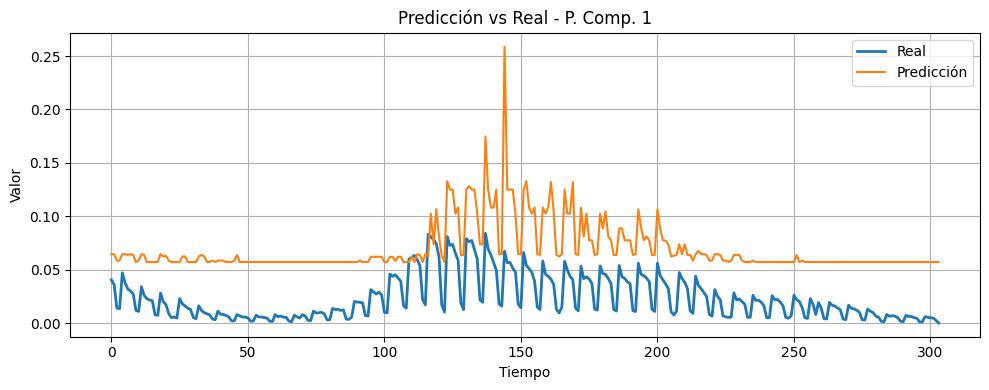

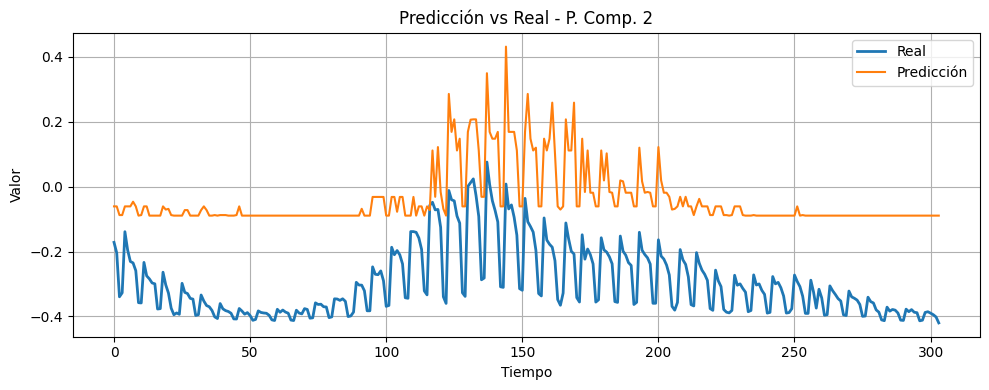

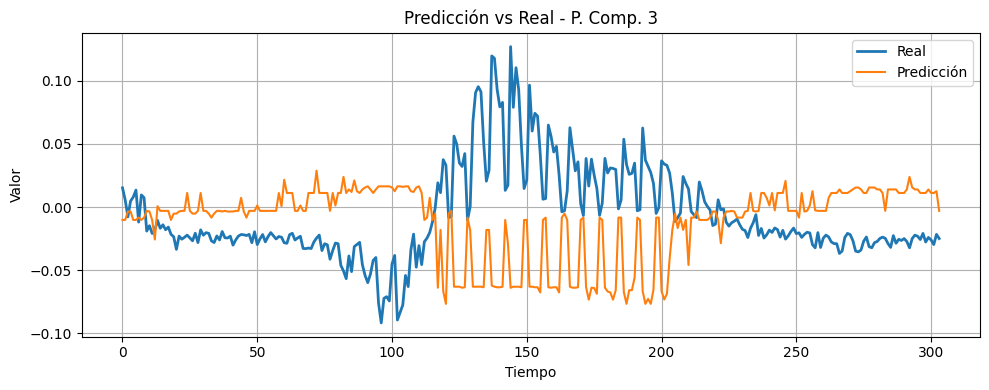

In [18]:
# == Gráfica de cada componente en test ==
for col in Y_test.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[col].values, label="Real", linewidth=2)
    plt.plot(pred_test_df[col].values, label="Predicción", linestyle="-")
    plt.title(f"Predicción vs Real - {col}")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
# Support Vector Machine
svm_regr = svm.SVR()
param_search_svm_regr = {
    'estimator__kernel': ['linear'],# , 'poly', 'rbf', 'sigmoid'
    'estimator__degree': [2],  # 3, 4, 5, 6
    'estimator__C': [0.001, 0.1, 1, 10, 100], # Puedo probar con [0.001, 0.01, 0.1, 1]
    'estimator__gamma': ['scale', 'auto'],
    'estimator__epsilon': [0.1, 0.2, 0.5, 1],
}
# Puedo agregar: 'estimator__gamma': ['scale', 'auto'], # Puedo probar con [0.001, 0.01, 0.1, 1]
# Puedo agregar: 'estimator__epsilon': [0.1, 0.2, 0.5, 1]

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['Nacional']]
y = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]

multioutput_svm = MultiOutputRegressor(svm_regr)
grid_search_svm = GridSearchCV(estimator=multioutput_svm, param_grid=param_search_svm_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_svm.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_svm = grid_search_svm.best_params_

print("==========================================================")
print("Best parameters for Support Vector Machine:")
print(best_params_svm)
print("----------------------------------------------------------")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters for Support Vector Machine:
{'estimator__C': 0.1, 'estimator__degree': 2, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'linear'}
----------------------------------------------------------


In [29]:
# === MultiOutputRegressor para predecir los 3 componentes principales ===
multi_svm = grid_search_svm.best_estimator_
multi_svm.fit(X_train, Y_train)

# === Predicciones ===
train_pred = multi_svm.predict(X_train)
test_pred = multi_svm.predict(X_test)

# === Convertir a DataFrames para análisis ===
pred_train_df = pd.DataFrame(train_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_train.index)
pred_test_df = pd.DataFrame(test_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_test.index)

Y_train.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
Y_test.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_train_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_test_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]

# === Utilizando el mismo proceso de evaluación como en la primer tarea, el cambio ahora es que se usa para los 3 componentes del análisis PCA ===
def evaluacion_metricas(true_df, pred_df):
    metrics = {}
    for col in true_df.columns:
        n = len(true_df[col])
        k = 1  # number of predictors (for each PCA component, only one output, but you may adjust if needed)
        mse = mean_squared_error(true_df[col], pred_df[col])
        mae = mean_absolute_error(true_df[col], pred_df[col])
        mape = mean_absolute_percentage_error(true_df[col], pred_df[col])
        r2 = r2_score(true_df[col], pred_df[col])
        rmse = mse ** 0.5

        # AIC and BIC for regression (assuming Gaussian errors)
        # log-likelihood for Gaussian: -n/2 * log(2*pi*sigma^2) - (1/(2*sigma^2)) * sum((y-yhat)^2)
        # For AIC/BIC, sigma^2 is estimated as mse
        if mse > 0:
            log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
            aic = 2 * k - 2 * log_likelihood
            bic = np.log(n) * k - 2 * log_likelihood
        else:
            aic = np.nan
            bic = np.nan

        # Amemiya's Prediction Criterion (APC)
        # APC = (1 + (k/n)) * mse
        apc = (1 + (k / n)) * mse

        metrics[col] = {
            "MSE": mse,
            "MAE": mae,
            "MAPE": mape,
            "R2": r2,
            "RMSE": rmse,
            "AIC": aic,
            "APC": apc,
            "BIC": bic
        }
    return pd.DataFrame(metrics).T

train_metrics = evaluacion_metricas(Y_train, pred_train_df)
test_metrics = evaluacion_metricas(Y_test, pred_test_df)

print("\n Métricas por componente - Train:")
print(train_metrics)
print("\n Métricas por componente - Test:")
print(test_metrics)


 Métricas por componente - Train:
                 MSE       MAE          MAPE        R2      RMSE          AIC  \
P. Comp. 1  0.016591  0.084718  2.742113e+12 -0.016740  0.128808 -1146.761216   
P. Comp. 2  0.490008  0.374028  1.834329e+00 -0.088331  0.700006  1937.459255   
P. Comp. 3  0.035095  0.106912  1.569916e+00 -0.003571  0.187336  -464.276391   

                 APC          BIC  
P. Comp. 1  0.016610 -1141.946673  
P. Comp. 2  0.490546  1942.273798  
P. Comp. 3  0.035133  -459.461848  

 Métricas por componente - Test:
                 MSE       MAE       MAPE         R2      RMSE          AIC  \
P. Comp. 1  0.008095  0.087407  13.549123 -18.291810  0.089974  -599.490004   
P. Comp. 2  0.050372  0.206786   1.064804  -3.369077  0.224438   -43.731832   
P. Comp. 3  0.001563  0.034129   1.727001  -0.189370  0.039541 -1099.385826   

                 APC          BIC  
P. Comp. 1  0.008122  -595.772977  
P. Comp. 2  0.050538   -40.014805  
P. Comp. 3  0.001569 -1095.668798  


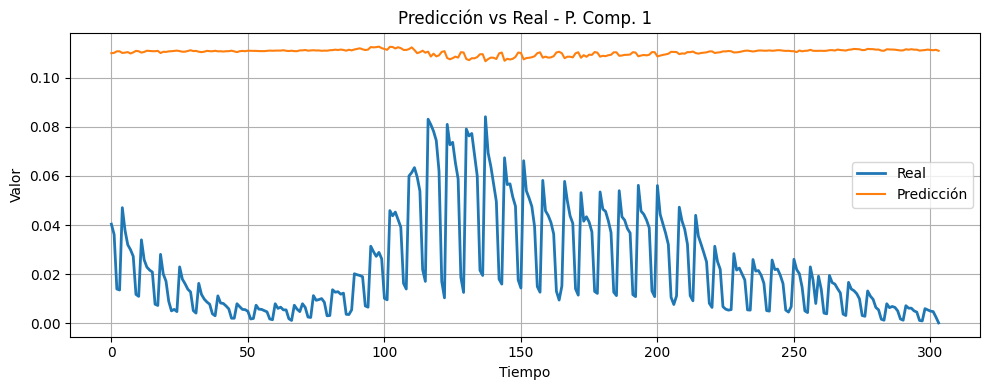

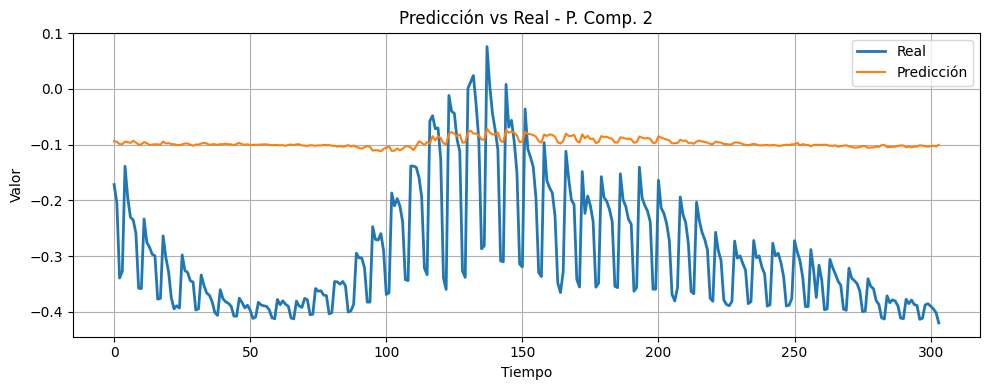

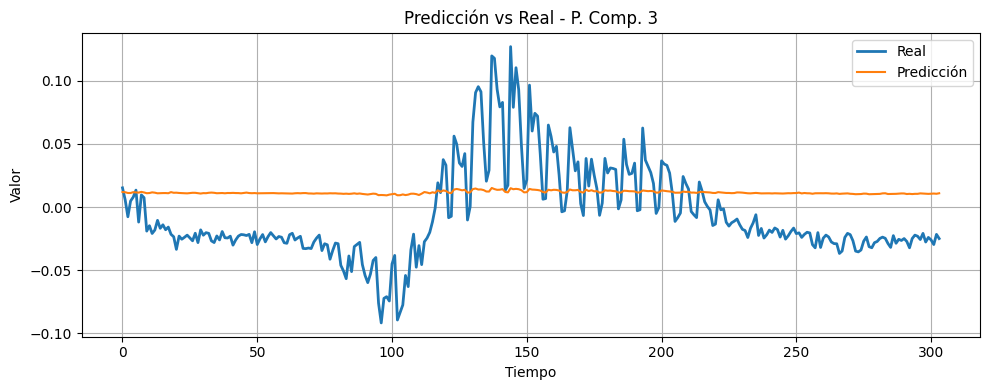

In [30]:
# == Gráfica de cada componente en test ==
for col in Y_test.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[col].values, label="Real", linewidth=2)
    plt.plot(pred_test_df[col].values, label="Predicción", linestyle="-")
    plt.title(f"Predicción vs Real - {col}")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()